In [14]:
import sys
import math
# import xlwings
import numpy as np
import pandas as pd
from yzutil import YzDataClient

In [16]:
sys.path.append('/home/dalong/bruce/Task8_Reproduce_Report/self_defined')

In [ ]:
from calc_inv_data import calc_inv_data
from process_total_inv import process_total_inv
from generate_inv_signal_seprank import generate_inv_signal_seprank
from generate_inv_signal_unirank import generate_inv_signal_unirank
from generate_ret_fnv import generate_ret_fnv

In [2]:
# Function for Concatenating and Summing Up Inventories of Single Product

# calculate total inventory for one product
def calc_inv_data(prod_id, inv_index_tb, yz, shift_inv):
    
    # - fetch data: single 'ya_id'
    # - each 'ya_id' corresponds to a distinct inventory type
    # - each commodity product's gross inventory level is comprised of
    # multiple inventory types/sources
    ya_id_list = list(inv_index_tb[inv_index_tb['product_id'] == prod_id]['ya_id'])
   
    # rename the field 'index_value' with corresponding inventory type
    # to avoid the 'identical field name' issue after joining data
    inv_type_list = list(inv_index_tb[inv_index_tb['product_id'] == prod_id]['inventory_type'])
    
    # use unit conversion coefficient to convert all units to MT (Metric Ton)
    conversion_coeff_list = list(inv_index_tb[inv_index_tb['product_id'] == prod_id]['conversion_coeff'])
    
    # use shift parameter to correct for 'future function':
    # -- the time gap between 'index_time' and 'insert_time'
    shift_list = list(inv_index_tb[inv_index_tb['product_id'] == prod_id]['shift'])
    
    join_df = pd.DataFrame()
    
    for i in range(len(ya_id_list)):
        
        # start and end dates here are 'calendar days' rather than 'trading days',
        # need to single out 'trading days' in later steps
        single_df = yz.get_alt_data(ya_id_list[i], fields=['index_time', 'index_value'], 
                                  start_date='2010-1-1', end_date='2017-12-31', latest=True)
        
        if shift_inv == 'shift_yes':
            # convert all units to MT (Metric Ton)
            single_df[inv_type_list[i]] = (single_df['index_value'] * conversion_coeff_list[i]).shift(shift_list[i])
        elif shift_inv == 'shift_no':
            # convert all units to MT (Metric Ton)
            single_df[inv_type_list[i]] = single_df['index_value'] * conversion_coeff_list[i]
        else:
            print("Input error for 'shift_inv' parameter. Please enter again. Only 2 input options: 'shift_yes', 'shift_no'.")
            sys.exit(1)
            
        # create timestamp from 'index_time'
        # drop duplicates and sort
        # set timestamp as row index in order to outer-join different inventory types later
        single_df['timestamp'] = pd.to_datetime(single_df['index_time'])
        single_df.drop_duplicates('timestamp', keep='last', inplace=True)
        single_df = single_df.sort_values(by=['timestamp'])
        single_df = single_df.set_index('timestamp')
        
        # - drop field 'index_time' to make dataframe more compact
        # - drop field 'index_value' to perform sum() correctly,
        #   otherwise the sum will be wrong/highly distorted
        single_df.drop(columns=['index_time', 'index_value'], inplace=True)
        
        # outer-join different inventory types into one dataframe
        join_df = pd.concat([join_df, single_df], axis=1, join='outer', sort=False)
    
    # use 'forward fill': key for sum
    join_df = join_df.fillna(method='ffill')
    
    # calculate total inventory level by summing up all inventory types
    join_df[prod_id] = join_df.sum(axis=1)
        
    return join_df

In [3]:
# Function for Concatenating and Matching Total Inventory of All the 22 Products

# integrate total inventory of all products into one dataframe
# perform data processing: match trading dates, length, frequency
def process_total_inv(inv_index_tb, yz, shift_inv):
    
    prod_id_list = list(inv_index_tb['product_id'].drop_duplicates())
    
    # pre-allocation
    inv_total_df = pd.DataFrame()
    
    for prod_id in prod_id_list:
    
        inv_single_df = calc_inv_data(prod_id, inv_index_tb, yz, shift_inv)
        
        inv_total_df = pd.concat([inv_total_df, round(inv_single_df[prod_id], 2)], axis=1, join='outer', sort=False)
    
    # fetch trading days
    trade_days = yz.get_trade_day(start_date="2010-01-01",end_date="2017-12-31")
    
    # create separate dataframe for calendar days and trading days
    # set timestamp index with identical name 'timestamp'
    calendardays_df = pd.DataFrame(inv_total_df.index, columns=['calendar_day'])
    calendardays_df['timestamp'] = calendardays_df['calendar_day']
    calendardays_df = calendardays_df.set_index('timestamp')
    
    tradingdays_df = pd.DataFrame(pd.to_datetime(trade_days), columns=['trading_day'])
    tradingdays_df['timestamp'] = tradingdays_df['trading_day']
    tradingdays_df = tradingdays_df.set_index('timestamp')
    
    # concatenate calendar days with trading days
    alldays_df = pd.concat([calendardays_df, tradingdays_df], axis=1, join='outer', sort=False)
    
    # create trading-day index
    tradingday_index = ~alldays_df['trading_day'].isnull()
    
    # retrieve trading-day data
    inv_total_tradingday_df = inv_total_df[tradingday_index]
    
    # match/convert frequency by 'forward fill' method
    inv_total_tradingday_df = inv_total_tradingday_df.fillna(method='ffill')
    
    return inv_total_tradingday_df


In [4]:
def generate_inv_signal_seprank(inv_total_tradingday_df, rolling, sig_threshold):

    signal_df = inv_total_tradingday_df.diff(rolling - 1) / inv_total_tradingday_df.shift(rolling - 1)

    for row in range(len(signal_df)):

        row_obs = signal_df.iloc[row]

        if not np.all(row_obs.isnull()):

            # single out negative change of inventory
            neg_chg_series = row_obs[row_obs < 0]
            # generate the list of products to long
            if len(neg_chg_series) > 0:
                # set top quintile (top 20%) by using 'round-up' approach
                signal_numbers = math.ceil(sig_threshold * len(neg_chg_series))
                # obtain products to long (buy)
                products_long = neg_chg_series.sort_values()[0:signal_numbers]
                ### print(neg_chg_series.sort_values(ascending=False)[0:signal_numbers].index, len(neg_chig_series.sort_values()[0:signal_numbers].index))
            
            # single out positive change of inventory
            pos_chg_series = row_obs[row_obs > 0]
            # generate the list of products to short
            if len(pos_chg_series) > 0:
                # set top quintile (top 20%) by using 'round-up' approach
                signal_numbers = math.ceil(sig_threshold * len(pos_chg_series))
                # obtain products to short (sell)
                products_short = pos_chg_series.sort_values(ascending=False)[0:signal_numbers]

            # key loop to create long/short signal            
            for col in range(len(signal_df.columns)):
                if signal_df.columns[col] in products_long.index:
                    signal_df.iloc[row, col] = 1  # long signal
                elif signal_df.columns[col] in products_short.index:
                    signal_df.iloc[row, col] = -1  # short signal
                else:
                    if not np.isnan(signal_df.iloc[row, col]):
                        signal_df.iloc[row, col] = 0      
        else:
            continue        

    return signal_df

In [ ]:
def generate_inv_signal_unirank(inv_total_tradingday_df, rolling, sig_threshold):

    signal_df = inv_total_tradingday_df.diff(rolling - 1) / inv_total_tradingday_df.shift(rolling - 1)

    for row in range(len(signal_df)):

        row_obs = signal_df.iloc[row]

        if not np.all(row_obs.isnull()):
            
            if len(row_obs.dropna()) > 1:
                # set quintile (top 20%) by using 'normal round' approach
                signal_numbers = round(sig_threshold * len(row_obs))
                # obtain products to long (buy)
                products_long = row_obs.sort_values()[0:signal_numbers]
                # obtain products to short (sell)
                products_short = row_obs.sort_values(ascending=False)[0:signal_numbers]
            else:
                if row_obs.dropna().iloc[0] > 0:
                    products_long = row_obs.dropna()
                elif row_obs.dropna().iloc[0] < 0:
                    products_short = row_obs.dropna()
                
            # key loop to create long/short signal            
            for col in range(len(signal_df.columns)):
                if signal_df.columns[col] in products_long.index:
                    signal_df.iloc[row, col] = 1  # long signal
                elif signal_df.columns[col] in products_short.index:
                    signal_df.iloc[row, col] = -1  # short signal
                else:
                    if not np.isnan(signal_df.iloc[row, col]):
                        signal_df.iloc[row, col] = 0      
        else:
            continue        

    return signal_df

In [109]:
def generate_ret_fnv(inv_index_tb, futures_data_df, signal_df, shift_sig, mode):

    futures_data_df.index.name = 'timestamp'
    futures_data_df.index = pd.to_datetime(futures_data_df.reset_index()['timestamp'])
    futures_dailyret_df = futures_data_df.diff(1) / futures_data_df.shift(1)
    
    signal_df.index.name = 'timestamp'
    signal_df.index = pd.to_datetime(signal_df.reset_index()['timestamp'])
    
    signal_df['transaction_cost'] = -0.0003 * abs(signal_df.fillna(0).diff(1)).sum(axis=1) 
    
    # generate daily weight series by applying 'equally weighted' scheme
    signal_df['weight_equal'] = pd.Series([np.nan for i in range(len(signal_df))])
    for row in range(len(signal_df)):
        targets = signal_df.iloc[row][(signal_df.iloc[row] == 1) | (signal_df.iloc[row] == -1)]
        if len(targets) > 0:
            signal_df.iloc[row, -1] = 1 / len(targets)
        else:
            signal_df.iloc[row, -1] = 0
    
    # correct for the position-building process/effect caused by using 'twap'
    if shift_sig == 'shift_yes':
        shift_param = 2
    elif shift_sig == 'shift_no':
        shift_param = 1
    else:
        print("Input error for 'shift_sig' parameter. Please enter again. Only 2 input options: 'shift_yes', 'shift_no'.")
        sys.exit(1)
        
    signal_shift_df = signal_df.shift(shift_param)
    
    portfolio_dailyret_df = (signal_shift_df[signal_shift_df.columns[0:-2]] * futures_dailyret_df).sum(axis=1)
    portfolio_dailyret_df = pd.DataFrame(signal_shift_df['weight_equal'] * portfolio_dailyret_df, columns=['daily_ret_portfolio'])
    portfolio_dailyret_df['ret_plus1'] = portfolio_dailyret_df['daily_ret_portfolio']
    portfolio_dailyret_df['ret_plus1'] = portfolio_dailyret_df['ret_plus1'].apply(lambda x: x + 1)
    portfolio_dailyret_df['transaction_cost'] = signal_shift_df['transaction_cost'] * signal_shift_df['weight_equal']
    portfolio_dailyret_df['ret_plus1_DeductTC'] = portfolio_dailyret_df['ret_plus1']
    portfolio_dailyret_df['ret_plus1_DeductTC'] = portfolio_dailyret_df.apply(lambda df: df['ret_plus1'] + df['transaction_cost'], axis=1)
    portfolio_dailyret_df['fund_net_value'] = portfolio_dailyret_df['ret_plus1']
    portfolio_dailyret_df['fund_net_value'] = portfolio_dailyret_df['fund_net_value'].cumprod()
    portfolio_dailyret_df['fund_net_value_DeductTC'] = portfolio_dailyret_df['ret_plus1_DeductTC']
    portfolio_dailyret_df['fund_net_value_DeductTC'] = portfolio_dailyret_df['fund_net_value_DeductTC'].cumprod()
    portfolio_dailyret_df = portfolio_dailyret_df.dropna()
    
    df_2017 = portfolio_dailyret_df[(portfolio_dailyret_df.index >= pd.to_datetime('2017-01-01')) & (portfolio_dailyret_df.index <= pd.to_datetime('2017-12-31'))]
    cumulative_ret_2017 = round((df_2017['fund_net_value'][-1] / df_2017['fund_net_value'][0]) - 1, 4)
    cumulative_ret_DeductTC_2017 = round((df_2017['fund_net_value_DeductTC'][-1] / df_2017['fund_net_value_DeductTC'][0]) - 1, 4)
    cumulative_ret_pair_2017 = [cumulative_ret_2017, cumulative_ret_DeductTC_2017]
    
    df_20170731 = portfolio_dailyret_df[(portfolio_dailyret_df.index >= pd.to_datetime('2017-01-01')) & (portfolio_dailyret_df.index <= pd.to_datetime('2017-07-31'))]
    cumulative_ret_20170731 = round((df_20170731['fund_net_value'][-1] / df_20170731['fund_net_value'][0]) - 1, 4)
    cumulative_ret_DeductTC_20170731 = round((df_20170731['fund_net_value_DeductTC'][-1] / df_20170731['fund_net_value_DeductTC'][0]) - 1, 4)
    cumulative_ret_pair_20170731 = [cumulative_ret_20170731, cumulative_ret_DeductTC_20170731]
    
    annualized_ret = round((portfolio_dailyret_df['fund_net_value'][-1] / portfolio_dailyret_df['fund_net_value'][0]) ** (1/8) - 1, 4)
    annualized_ret_DeductTC = round((portfolio_dailyret_df['fund_net_value_DeductTC'][-1] / portfolio_dailyret_df['fund_net_value_DeductTC'][0]) ** (1/8) - 1, 4)
    annualized_ret_pair = [annualized_ret, annualized_ret_DeductTC]
    
    portfolio_dailyret_df_20170731 = portfolio_dailyret_df[(portfolio_dailyret_df.index >= pd.to_datetime('2010-01-01')) & (portfolio_dailyret_df.index <= pd.to_datetime('2017-07-31'))]
    annualized_ret_20170731 = round((portfolio_dailyret_df_20170731['fund_net_value'][-1] / portfolio_dailyret_df_20170731['fund_net_value'][0]) ** (1/(7+(7/12))) - 1, 4)
    annualized_ret_DeductTC_20170731 = round((portfolio_dailyret_df_20170731['fund_net_value_DeductTC'][-1] / portfolio_dailyret_df_20170731['fund_net_value_DeductTC'][0]) ** (1/(7+(7/12))) - 1, 4)
    annualized_ret_pair_20170731 = [annualized_ret_20170731, annualized_ret_DeductTC_20170731]
    
    if mode == 'ret_annualized_pair':
        return annualized_ret_pair
    elif mode == 'ret_annualized_pair_20170731':
        return annualized_ret_pair_20170731
    elif mode == 'ret_cumulative_pair_20170731':
        return cumulative_ret_pair_20170731
    elif mode == 'ret_cumulative_pair_2017':
        return cumulative_ret_pair_2017
    elif mode == 'ret_portfolio_df_20170731':
        return portfolio_dailyret_df_20170731
    elif mode == 'ret_portfolio_df':
        return portfolio_dailyret_df
    else:
        print("Input error for 'mode' parameter. Please enter again. Only 2 input options: 'ret_pair', 'ret_port_df'.")
        sys.exit(1)

#     return (annualized_ret, portfolio_dailyret_df['fund_net_value'])

In [80]:
%%time

# initiate data api obj
yz = YzDataClient('bruce@yangzeinvest.com', 'bruce123')

# load data
inv_index_tb = pd.read_csv('/Users/apple/desktop/Yangze_Investment/Task8_Reproduce_Report/data/inventory_data_index.csv')
futures_data_df = pd.read_csv('/Users/apple/desktop/Yangze_Investment/Task8_Reproduce_Report/data/futures_data.csv', index_col=0)

# set parameters
SIG_THRESHOLD = 0.2

mode = 'ret_annualized_pair_20170731'

shift_inv, shift_sig = 'shift_yes', 'shift_yes'

rolling_list = [i for i in range(10, 110, 10)]

annualized_ret_df = pd.DataFrame()

# main function calls
inv_total_tradingday_df = process_total_inv(inv_index_tb, yz, shift_inv)

for rolling in rolling_list:
    
    # main function call
    signal_df = generate_inv_signal_seprank(inv_total_tradingday_df, rolling, SIG_THRESHOLD)
    
    annualized_ret_pair = generate_ret_fnv(inv_index_tb, futures_data_df, signal_df, shift_sig, mode)
    
    annualized_ret_pair_df = pd.DataFrame(annualized_ret_pair)
    
    annualized_ret_df = pd.concat([annualized_ret_df, annualized_ret_pair_df], axis=1)
    
annualized_ret_df.index = ['annualized_ret', 'annualized_ret_DeductTC']
annualized_ret_df.columns = rolling_list

annualized_ret_df

Login YzData Success
CPU times: user 3min, sys: 1.72 s, total: 3min 2s
Wall time: 3min 16s


,10,20,30,40,50,60,70,80,90,100
annualized_ret,0.0564,0.0096,-0.0139,-0.0021,-0.0083,0.0012,-0.0095,0.0287,0.0494,0.0536
annualized_ret_DeductTC,0.0298,-0.0081,-0.0272,-0.0139,-0.0189,-0.0086,-0.0186,0.0192,0.0411,0.0454


In [98]:
%%time

# initiate data api obj
yz = YzDataClient('bruce@yangzeinvest.com', 'bruce123')

# load data
inv_index_tb = pd.read_csv('/Users/apple/desktop/Yangze_Investment/Task8_Reproduce_Report/data/inventory_data_index.csv')
futures_data_df = pd.read_csv('/Users/apple/desktop/Yangze_Investment/Task8_Reproduce_Report/data/futures_data.csv', index_col=0)

# set parameters
SIG_THRESHOLD = 0.2

mode = 'ret_cumulative_pair_20170731'

shift_inv, shift_sig = 'shift_yes', 'shift_yes'

rolling_list = [i for i in range(10, 110, 10)]

cumulative_ret_2017_df = pd.DataFrame()

# main function calls
inv_total_tradingday_df = process_total_inv(inv_index_tb, yz, shift_inv)

for rolling in rolling_list:
    
    # main function call
    signal_df = generate_inv_signal_seprank(inv_total_tradingday_df, rolling, SIG_THRESHOLD)
    
    cumulative_ret_pair_2017 = generate_ret_fnv(inv_index_tb, futures_data_df, signal_df, shift_sig, mode)
    
    cumulative_ret_pair_2017_df = pd.DataFrame(cumulative_ret_pair_2017)
    
    cumulative_ret_2017_df = pd.concat([cumulative_ret_2017_df, cumulative_ret_pair_2017_df], axis=1)
    
cumulative_ret_2017_df.index = ['cumulative_ret', 'cumulative_ret_DeductTC']
cumulative_ret_2017_df.columns = rolling_list

cumulative_ret_2017_df

Login YzData Success
CPU times: user 9min 31s, sys: 11.3 s, total: 9min 42s
Wall time: 10min 12s


,10,20,30,40,50,60,70,80,90,100
cumulative_ret,-0.0303,-0.0193,0.1349,0.1170,0.0787,0.0445,0.0489,0.0810,0.0269,-0.0043
cumulative_ret_DeductTC,-0.0415,-0.0294,0.1261,0.1089,0.0711,0.0365,0.0424,0.0749,0.0223,-0.0110


In [110]:
%%time

# initiate data api obj
yz = YzDataClient('bruce@yangzeinvest.com', 'bruce123')

# load data
inv_index_tb = pd.read_csv('/Users/apple/desktop/Yangze_Investment/Task8_Reproduce_Report/data/inventory_data_index.csv')
futures_data_df = pd.read_csv('/Users/apple/desktop/Yangze_Investment/Task8_Reproduce_Report/data/futures_data.csv', index_col=0)

# set parameters
SIG_THRESHOLD = 0.2

mode = 'ret_portfolio_df_20170731'

shift_inv, shift_sig = 'shift_yes', 'shift_yes'

rolling_list = [90]

annualized_ret_df = pd.DataFrame()

# main function calls
inv_total_tradingday_df = process_total_inv(inv_index_tb, yz, shift_inv)

for rolling in rolling_list:
    
    # main function call
    signal_df = generate_inv_signal_seprank(inv_total_tradingday_df, rolling, SIG_THRESHOLD)
    
    portfolio_dailyret_df = generate_ret_fnv(inv_index_tb, futures_data_df, signal_df, shift_sig, mode)

Login YzData Success
CPU times: user 1min 25s, sys: 2.04 s, total: 1min 27s
Wall time: 1min 49s


In [81]:
# annualized_ret_df.columns = rolling_list

annualized_ret_df.to_csv('/Users/apple/desktop/Yangze_Investment/Task8_Reproduce_Report/results/annualized_ret_df_20170731.csv')

In [100]:
cumulative_ret_2017_df.to_csv('/Users/apple/desktop/Yangze_Investment/Task8_Reproduce_Report/results/cumulative_ret_20170731_df.csv')

In [111]:
portfolio_dailyret_df.to_csv('/Users/apple/desktop/Yangze_Investment/Task8_Reproduce_Report/results/portfolio_dailyret_df.csv')

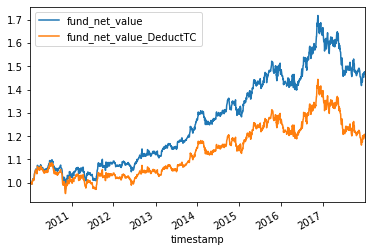

In [36]:
generate_ret_fnv(inv_index_tb, futures_data_df, signal_df, shift_sig, 'ret_port_df')[['fund_net_value','fund_net_value_DeductTC']].plot()

In [54]:
rolling

100

In [58]:
a = generate_ret_fnv(inv_index_tb, futures_data_df, signal_df, shift_sig, 'ret_portfolio_df')

In [63]:
a[(a.index >= pd.to_datetime('2017-01-01')) & (a.index <= pd.to_datetime('2017-12-31'))]

,daily_ret_portfolio,ret_plus1,transaction_cost,ret_plus1_DeductTC,fund_net_value,fund_net_value_DeductTC
timestamp,,,,,,
2017-01-03,0.000180,1.000180,-2.697572e-15,1.000180,1.492482,1.415226
2017-01-04,0.002148,1.002148,-6.201861e-05,1.002086,1.495689,1.418179
2017-01-05,0.003792,1.003792,-1.860000e-08,1.003792,1.501361,1.423557
2017-01-06,0.000684,1.000684,-5.578327e-12,1.000684,1.502388,1.424531
2017-01-09,0.007707,1.007707,-1.672996e-15,1.007707,1.513967,1.435510
2017-01-10,0.004581,1.004581,-5.017483e-19,1.004581,1.520903,1.442087
2017-01-11,-0.003733,0.996267,-1.517122e-04,0.996116,1.515226,1.436485
2017-01-12,-0.008937,0.991063,-6.203601e-05,0.991001,1.501684,1.423558
2017-01-13,-0.000888,0.999112,-2.400534e-04,0.998872,1.500350,1.421952


In [ ]:
inv_index_tb = pd.read_csv('/Users/apple/desktop/Yangze_Investment/Task8_Reproduce_Report/data/inventory_data_index.csv')

inv_total_tradingday_df = pd.read_csv('/Users/apple/desktop/Yangze_Investment/Task8_Reproduce_Report/data/inventory_total_TradingDays.csv', index_col=0)

futures_data_df = pd.read_csv('/Users/apple/desktop/Yangze_Investment/Task8_Reproduce_Report/data/futures_data.csv', index_col=0)

rolling_list = [i for i in range(10, 110, 10)]

annualized_ret_list = []

for rolling in rolling_list:
    
    # main function call
    signal_df = generate_inv_signal_seprank(inv_total_tradingday_df, rolling)

    annualized_ret_list.append(generate_ret_fnv(inv_index_tb, futures_data_df, signal_df, shift_sig))
    
annualized_ret_list

In [25]:
signal_df = pd.read_csv('/Users/apple/desktop/Yangze_Investment/Task8_Reproduce_Report/data/signal_df.csv', index_col=0)

signal_df['transaction_cost'] = -0.0003 * abs(signal_df.fillna(0).diff(1)).sum(axis=0)

In [27]:
abs(signal_df.diff(1)).sum(axis=0)

al                   24.0
cu                  190.0
ni                   54.0
pb                   90.0
sn                  244.0
zn                  101.0
bu                  103.0
l                   184.0
MA                  187.0
pp                   69.0
TA                  292.0
v                   166.0
FG                   51.0
hc                   98.0
i                    66.0
j                   159.0
jm                  145.0
rb                  219.0
ZC                  228.0
ag                   28.0
au                   58.0
ru                  204.0
transaction_cost      0.0
dtype: float64

In [12]:
import numpy as np
import pandas as pd

pd.Series([np.nan, 2]).dropna().index

Int64Index([1], dtype='int64')